# Descripción del ejercicio

Has recibido una tarea analítica de una tienda en línea internacional. Tus predecesores no consiguieron completarla: lanzaron una prueba A/B y luego abandonaron (para iniciar una granja de sandías en Brasil). Solo dejaron las especificaciones técnicas y los resultados de las pruebas.

## Descripción técnica

- Nombre de la prueba: `recommender_system_test`
- Grupos: А (control), B (nuevo embudo de pago)
- Launch date: 2020-12-07
- Fecha en la que dejaron de aceptar nuevos usuarios: 2020-12-21
- Fecha de finalización: 2021-01-01
- Audiencia: 15% de los nuevos usuarios de la región de la UE
- Propósito de la prueba: probar cambios relacionados con la introducción de un sistema de recomendaciones mejorado
- Resultado esperado: dentro de los 14 días posteriores a la inscripción, los usuarios mostrarán una mejor conversión en vistas de la página del producto (el evento `product_page`), instancias de agregar artículos al carrito de compras (`product_card`) y compras (`purchase`). En cada etapa del embudo `product_page → product_card → purchase`, habrá al menos un 10% de aumento.
- Número previsto de participantes de la prueba: 6 000

## Descripción de los datos

- `ab_project_marketing_events_us.csv`: el calendario de eventos de marketing para 2020
- `final_ab_new_users_upd_us.csv`: todos los usuarios que se registraron en la tienda en línea desde el 7 hasta el 21 de diciembre de 2020
- `final_ab_events_upd_us.csv`: todos los eventos de los nuevos usuarios en el período comprendido entre el 7 de diciembre de 2020 y el 1 de enero de 2021
- `final_ab_participants_upd_us.csv`: tabla con los datos de los participantes de la prueba

Estructura `ab_project_marketing_events_us.csv`:

- `name`: el nombre del evento de marketing
- `regions`: regiones donde se llevará a cabo la campaña publicitaria
- `start_dt`: fecha de inicio de la campaña
- `finish_dt`: fecha de finalización de la campaña

Estructura `final_ab_new_users_upd_us.csv`:

- `user_id`
- `first_date`: fecha de inscripción
- `region`
- `device`: dispositivo utilizado para la inscripción

Estructura `final_ab_events_upd_us.csv`:

- `user_id`
- `event_dt`: fecha y hora del evento
- `event_name`: nombre del tipo de evento
- `details`: datos adicionales sobre el evento (por ejemplo, el pedido total en USD para los eventos `purchase`)

Estructura `final_ab_participants_upd_us.csv`:

- `user_id`
- `ab_test`: nombre de la prueba
- `group`: el grupo de prueba al que pertenecía el usuario

## Objetivos del estudio

El principal objetivo de la prueba A/B, denominada recommender_system_test, es evaluar la eficacia de un sistema de recomendaciones mejorado en la tienda en línea. La eficacia se medirá en términos de mejoras en la conversión a lo largo de un embudo específico: vistas de la página del producto (product_page), agregar artículos al carrito de compras (product_card) y compras (purchase).

Las expectativas son las siguientes:

* Los usuarios, dentro de los 14 días posteriores a la inscripción, mostrarán una mejor conversión en cada etapa del embudo.
* Se espera un aumento del 10% en la conversión en cada etapa del embudo.

La prueba se lleva a cabo en dos grupos:

* Grupo A (control)
* Grupo B (nuevo embudo de pago con el sistema de recomendaciones mejorado)
Solo el 15% de los nuevos usuarios de la región de la UE fueron seleccionados para la prueba, y se preveía que el número total de participantes sería de 6,000.

# Pasos a seguir

- Inicialización
    - Cargar y explorar los datos.
    - Verificar si es necesario convertir los tipos de datos.
    - Identificar y tratar valores ausentes.
    - Identificar y tratar valores duplicados.
- Análisis exploratorio de datos.
    - Estudiar la conversión en las diferentes etapas del embudo.
    - Verificar la distribución equitativa del número de eventos por usuario entre las muestras.
    - Comprobar si hay usuarios que están presentes en ambas muestras.
    - Analizar la distribución del número de eventos entre los días.
    - Identificar peculiaridades en los datos que deban tenerse en cuenta antes de iniciar la prueba A/B.
- Evaluar los resultados de la prueba A/B.
    - Prueba de hipotesis Z.
- Conclusión

#Inicialización

## Cargar y explorar los datos.

In [1]:
#importamos librerias
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from scipy import stats as st
import math as mth
import os
import re

In [2]:
#Cargamos los archivos de datos
try:
  marketing_events = pd.read_csv('/datasets/ab_project_marketing_events_us.csv', parse_dates=['start_dt','finish_dt'])
except:
  marketing_events = pd.read_csv('/content/ab_project_marketing_events_us.csv', parse_dates=['start_dt','finish_dt'])

try:
  new_users = pd.read_csv('/datasets/final_ab_new_users_upd_us.csv', parse_dates=['first_date'])
except:
  new_users = pd.read_csv('/content/final_ab_new_users_upd_us.csv', parse_dates=['first_date'])

try:
  events = pd.read_csv('/datasets/final_ab_events_upd_us.csv', parse_dates=['event_dt'])
except:
  events = pd.read_csv('/content/final_ab_events_upd_us.csv', parse_dates=['event_dt'])

try:
  participants = pd.read_csv('/datasets/final_ab_participants_upd_us.csv')
except:
  participants = pd.read_csv('/content/final_ab_participants_upd_us.csv')

In [3]:
# previsualizar los datos cargados
marketing_events.info()

# devolver las n filas superiores del dataframe
marketing_events.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


No parece haber nada extraño en el dataset.

In [4]:
# previsualizar los datos cargados
new_users.info()

# devolver las n filas superiores del dataframe
new_users.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     58703 non-null  object        
 1   first_date  58703 non-null  datetime64[ns]
 2   region      58703 non-null  object        
 3   device      58703 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.8+ MB


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone
5,137119F5A9E69421,2020-12-07,N.America,iPhone
6,62F0C741CC42D0CC,2020-12-07,APAC,iPhone
7,8942E64218C9A1ED,2020-12-07,EU,PC
8,499AFACF904BBAE3,2020-12-07,N.America,iPhone
9,FFCEA1179C253104,2020-12-07,EU,Android


No parece haber nada extraño en el dataset.

In [5]:
# previsualizar los datos cargados
events.info()

# devolver las n filas superiores del dataframe
events.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     423761 non-null  object        
 1   event_dt    423761 non-null  datetime64[ns]
 2   event_name  423761 non-null  object        
 3   details     60314 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 12.9+ MB


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99
5,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99
6,6B2F726BFD5F8220,2020-12-07 11:27:42,purchase,4.99
7,BEB37715AACF53B0,2020-12-07 04:26:15,purchase,4.99
8,B5FA27F582227197,2020-12-07 01:46:37,purchase,4.99
9,A92195E3CFB83DBD,2020-12-07 00:32:07,purchase,4.99


No parece haber nada extraño en el dataset.

In [6]:
# previsualizar los datos cargados
participants.info()

# devolver las n filas superiores del dataframe
participants.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test
5,7473E0943673C09E,A,recommender_system_test
6,C46FE336D240A054,A,recommender_system_test
7,92CB588012C10D3D,A,recommender_system_test
8,B3A2485649E4A012,A,recommender_system_test
9,66FC298441D50783,A,recommender_system_test


In [7]:
#Validando las pruebas
participants["ab_test"].value_counts()

interface_eu_test          10850
recommender_system_test     3675
Name: ab_test, dtype: int64

En el dataset de participantes parece haber 10.850 entradas de otra prueba. Descartaremos las filas que contengan interface_eu_test ya que esas filas no son necesarias en el alcance de este análisis.

In [8]:
participants = participants.loc[participants['ab_test']=='recommender_system_test'].reset_index(drop=True)
participants

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test
...,...,...,...
3670,053FB26D6D49EDDC,A,recommender_system_test
3671,9D263B8EF15CF188,B,recommender_system_test
3672,F2FBBA33F37DEC46,A,recommender_system_test
3673,29C92313A98B1176,B,recommender_system_test


In [9]:
#Evaluando cantidad de usuarios
participants['user_id'].nunique()

3675

Identificamos que en el dataset de participantes habían datos de un evento que no se considera dentro del estudio. Es importante considerar que se espera que la cantidad de participantes para el test recommender_system_test sea de 6000 pero quitando los datos de interface_eu_test nos hemos quedado con solo 3675 participantes.

## Verificar si es necesario convertir los tipos de datos.

In [10]:
# Verificar los tipos de datos de cada archivo
datasets = [marketing_events, events, new_users, participants]
dataset_names = ["Marketing Events", "Events", "New Users", "Participants"]

data_types = {}
for name, dataset in zip(dataset_names, datasets):
    data_types[name] = dataset.dtypes

data_types

{'Marketing Events': name                 object
 regions              object
 start_dt     datetime64[ns]
 finish_dt    datetime64[ns]
 dtype: object,
 'Events': user_id               object
 event_dt      datetime64[ns]
 event_name            object
 details              float64
 dtype: object,
 'New Users': user_id               object
 first_date    datetime64[ns]
 region                object
 device                object
 dtype: object,
 'Participants': user_id    object
 group      object
 ab_test    object
 dtype: object}

Los tipos de datos son los apropiados para su contenido.

## Identificar y tratar valores ausentes.

In [11]:
# Verificar valores ausentes para cada conjunto de datos
missing_values = {}
for name, dataset in zip(dataset_names, datasets):
    missing_values[name] = dataset.isnull().sum()

missing_values

{'Marketing Events': name         0
 regions      0
 start_dt     0
 finish_dt    0
 dtype: int64,
 'Events': user_id            0
 event_dt           0
 event_name         0
 details       363447
 dtype: int64,
 'New Users': user_id       0
 first_date    0
 region        0
 device        0
 dtype: int64,
 'Participants': user_id    0
 group      0
 ab_test    0
 dtype: int64}

En la tabla "Events", la columna details tiene 363,447 valores ausentes. Dado que esta columna contiene información adicional sobre el evento (por ejemplo, el total del pedido en USD para eventos de compra), es posible que estos valores ausentes correspondan a eventos que no son compras y, por lo tanto, no tendrían un valor asociado.

Para confirmar esta suposición, verificaremos si estos valores ausentes en details corresponden a eventos que no son purchase.

In [12]:
# Verificar los tipos de eventos que tienen valores ausentes en 'details'
missing_details_event_types = events[events['details'].isnull()]['event_name'].value_counts()
missing_details_event_types

login           182465
product_page    120862
product_cart     60120
Name: event_name, dtype: int64

Como se sospechaba, los valores ausentes en la columna details corresponden a eventos que no son de tipo purchase (login, product_page , product_cart). Por lo tanto, los valores ausentes en la columna details son esperados y no requieren tratamiento, renombraremos la columna para que sea más descriptiva y rellenaremos los valores ausentes con 0.

In [13]:
#Renombrando la columna details por purchase_size
events.rename(columns={"details": "purchase_size"}, inplace=True)
#Rellenaremos los valores ausentes con 0
events['purchase_size'].fillna(0.0, inplace=True)

## Identificar y tratar valores duplicados.

A continuación, verificaremos si hay valores duplicados en los conjuntos de datos.

In [14]:
# Verificar valores duplicados para cada conjunto de datos
duplicated_values = {}
for name, dataset in zip(dataset_names, datasets):
    duplicated_values[name] = dataset.duplicated().sum()

duplicated_values

{'Marketing Events': 0, 'Events': 0, 'New Users': 0, 'Participants': 0}

No hay valores duplicados en ninguno de los conjuntos de datos.

Con los tipos de datos correctos, los valores ausentes verificados y sin duplicados, estamos listos para proceder con el Análisis Exploratorio de Datos (EDA).

# Análisis Exploratorio de Datos (EDA)

Vamos a abordar el EDA en los siguientes pasos:

1. Estudiar la conversión en las diferentes etapas del embudo.
2. Verificar la distribución equitativa del número de eventos por usuario entre las muestras.
3. Comprobar si hay usuarios que están presentes en ambas muestras.
4. Analizar la distribución del número de eventos entre los días.
5. Identificar peculiaridades en los datos que deban tenerse en cuenta antes de iniciar la prueba A/B.

## Estudiar la conversión en las diferentes etapas del embudo

Queremos entender cuántos usuarios pasan por cada etapa del embudo (product_page, product_cart, purchase) y cómo se comparan estos números entre el grupo de control (Grupo A) y el grupo de prueba (Grupo B).

Primero, combinaremos la tabla "Events" con la tabla "Participants" para obtener detalles del grupo al que pertenece cada usuario para cada evento. Luego, calcularemos el número de usuarios en cada etapa del embudo para ambos grupos.

In [15]:
# Combinar las tablas "Events" y "Participants" basado en "user_id"
combined_data = events.merge(participants, on='user_id', how='inner')

# Calcular el número de usuarios únicos en cada etapa del embudo para ambos grupos
funnel = combined_data.groupby(['group', 'event_name']).agg({'user_id': 'nunique'}).reset_index()
funnel.columns = ['Group', 'Event', 'Unique Users']
funnel = funnel.sort_values(by='Unique Users', ascending=False)

funnel.pivot(index='Event', columns='Group', values='Unique Users')

Group,A,B
Event,,
login,2747,927
product_cart,824,255
product_page,1780,523
purchase,872,256


In [16]:
# Graficar el embudo de conversión con etiquetas de grupo
funnelg = px.funnel(funnel, x='Unique Users', y='Event', color='Group', title="Embudo de Conversión")

funnelg.show()

El embudo muestra la conversión en las diferentes etapas del embudo para ambos grupos. Podemos ver que el Grupo A tiene más usuarios en cada etapa del embudo en comparación con el Grupo B. Sin embargo, es importante recordar que el tamaño de muestra del Grupo A es probablemente más grande que el del Grupo B.

También podemos ver que hay más usuarios que realizaron compras que usarios que añadieron productos a su carrito, quizas la web tiene una opcion de "comprar ahora" y omiten el paso del carrito.

Para tener una idea más clara, calcularemos las tasas de conversión para cada etapa del embudo, que es el número de usuarios en una etapa particular dividido por el número total de usuarios.

In [17]:
# Calcular las tasas de conversión
total_users_A = funnel[funnel['Group'] == 'A']['Unique Users'].sum()
total_users_B = funnel[funnel['Group'] == 'B']['Unique Users'].sum()

funnel['Conversion Rate'] = 0
funnel.loc[funnel['Group'] == 'A', 'Conversion Rate'] = funnel['Unique Users'] / total_users_A
funnel.loc[funnel['Group'] == 'B', 'Conversion Rate'] = funnel['Unique Users'] / total_users_B

# Mostrar las tasas de conversión en formato pivot
conversion_rates = funnel.pivot(index='Event', columns='Group', values='Conversion Rate')
conversion_rates

Group,A,B
Event,,
login,0.441427,0.472718
product_cart,0.132412,0.130036
product_page,0.286036,0.266701
purchase,0.140125,0.130546


El Grupo B tiene una tasa de conversión ligeramente más alta para el evento login en comparación con el Grupo A.
Para los eventos product_page, product_cart y purchase, el Grupo A tiene tasas de conversión ligeramente más altas en comparación con el Grupo B.

## Verificar la distribución equitativa del número de eventos por usuario entre las muestras.

Procederemos con el segundo paso: verificar si el número de eventos por usuario está distribuido equitativamente entre las muestras.

In [18]:
# Calcular el número de eventos por usuario para cada grupo
events_per_user = combined_data.groupby(['group', 'user_id']).agg({'event_name': 'count'}).reset_index()

# Separar los datos por grupo
group_A_events = events_per_user[events_per_user['group'] == 'A']['event_name']
group_B_events = events_per_user[events_per_user['group'] == 'B']['event_name']

# Calcular estadísticas descriptivas para cada grupo
stats_A = group_A_events.describe()
stats_B = group_B_events.describe()

pd.DataFrame({'Group A': stats_A, 'Group B': stats_B})

,Group A,Group B
count,2747.000000,928.00000
mean,6.780852,5.69181
std,3.729768,3.45035
min,1.000000,1.00000
25%,4.000000,3.00000
50%,6.000000,5.00000
75%,9.000000,8.00000
max,24.000000,28.00000


- El Grupo A tiene, en promedio, más eventos por usuario (6.78) en comparación con el Grupo B (5.69).
- La distribución de eventos por usuario en ambos grupos tiene una variabilidad similar (desviación estándar cercana).
- La mediana del número de eventos por usuario es ligeramente mayor en el Grupo A en comparación con el Grupo B.

## Comprobar si hay usuarios que están presentes en ambas muestras.

Queremos asegurarnos de que ningún usuario esté en ambos grupos, A y B, al mismo tiempo.

In [19]:
# Verificar usuarios duplicados entre los grupos
duplicated_users = participants[participants.duplicated(subset='user_id', keep=False)]
users_in_both_groups = duplicated_users['user_id'].nunique()
print("Hay", users_in_both_groups, "usuarios en ambos grupos.")

Hay 0 usuarios en ambos grupos.


No hay usuarios que están presentes en ambos grupos, A y B. Esto es lo ideal porque si un usuario está en ambos grupos, puede introducir un sesgo en los resultados de la prueba A/B. Es importante que un usuario pertenezca a un solo grupo para garantizar que los grupos sean mutuamente excluyentes y garantizar la validez de la prueba.

## Analizar la distribución del número de eventos entre los días.

Antes de tomar medidas, pasemos al cuarto paso: analizar la distribución del número de eventos entre los días. Esto nos ayudará a comprender si hay algún patrón o tendencia en la distribución temporal de los eventos.

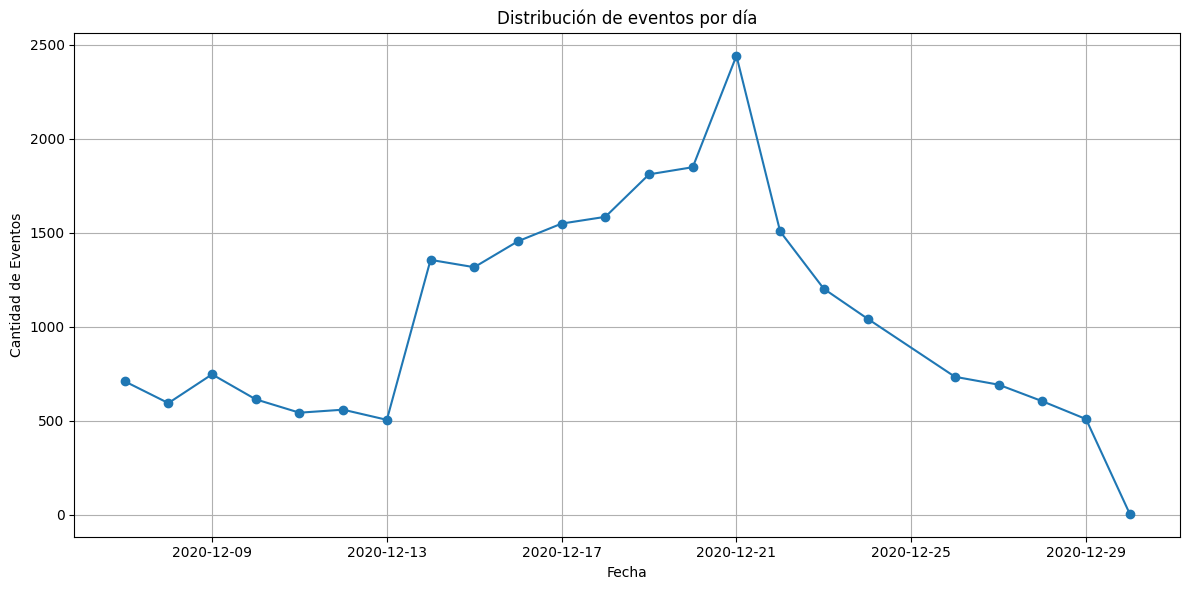

In [20]:
# Calcular el número de eventos por día
events_per_day = combined_data.groupby(['event_dt']).agg({'event_name': 'count'}).reset_index()

# Cambiar el nombre de las columnas para reflejar el contenido
events_per_day.columns = ['Date', 'Number of Events']

# Agrupar los eventos por día
events_per_day['Date'] = events_per_day['Date'].dt.date
daily_events = events_per_day.groupby('Date').sum().reset_index()

# Visualizar la distribución de eventos por día
plt.figure(figsize=(12, 6))
plt.plot(daily_events['Date'], daily_events['Number of Events'], marker='o')
plt.title('Distribución de eventos por día')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Eventos')
plt.grid(True)
plt.tight_layout()
plt.show()

La gráfica muestra la distribución del número de eventos por día desde el 7 de diciembre de 2020 hasta el 30 de diciembre de 2020. Los eventos coincidieron con fechas festivas (navidad/año nuevo).

Podemos observar que:

- Hay un pico de actividad alrededor del 13 de diciembre.
- Después del pico, hay una disminución en la actividad hasta alrededor del 21 de diciembre, seguido de un aumento constante en la actividad.

Es posible que este pico de actividad se deba a las festividades, ya que se encuentra justo antes de navidad.

## Identificar peculiaridades en los datos que deban tenerse en cuenta antes de iniciar la prueba A/B.

Debemos considerar si hay algún evento de marketing que pueda haber influenciado estos resultados. Revisemos el calendario de eventos de marketing para el mismo período.

In [21]:
# Filtrar el calendario de eventos de marketing para el período relevante
start_date = combined_data['event_dt'].min()
end_date = combined_data['event_dt'].max()

marketing_events[(marketing_events['start_dt'] <= end_date) &
                 (marketing_events['finish_dt'] >= start_date)]

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


Durante el período de la prueba A/B, hubo dos eventos de marketing:

1. Christmas & New Year Promo:

- Regiones: EU (Unión Europea) y Norteamérica
- Fecha de inicio: 25 de diciembre de 2020
- Fecha de finalización: 3 de enero de 2021

2. CIS New Year Gift Lottery:

- Regiones: CIS (Comunidad de Estados Independientes)
- Fecha de inicio: 30 de diciembre de 2020
- Fecha de finalización: 7 de enero de 2021

Dado que la prueba A/B se llevó a cabo específicamente en la región de la UE, solo el evento "Christmas & New Year Promo" podría haber afectado la prueba. Es crucial tener en cuenta este evento al interpretar los resultados de la prueba A/B, ya que las campañas de marketing pueden influir en el comportamiento del usuario y, por lo tanto, en los resultados de la prueba.

- Hemos analizado la conversión en las diferentes etapas del embudo y observado que el Grupo A tiene tasas de conversión ligeramente más altas en comparación con el Grupo B para las etapas product_page, product_cart y purchase.
- El número medio de eventos por usuario es más alto en el Grupo A en comparación con el Grupo B.
- No hay usuarios que están presentes en ambos grupos.
- Observamos la distribución temporal de los eventos y notamos un pico de actividad alrededor del 13 de diciembre y un aumento constante después del 21 de diciembre. Hay eventos de marketing que pudieron generar este aumento de eventos.

# Evaluar los resultados de la prueba A/B

Para evaluar los resultados, primero analizaremos la conversión en las diferentes etapas del embudo para los grupos limpios. Luego, utilizaremos una prueba z para comprobar si hay una diferencia estadísticamente significativa en las proporciones de conversión entre los dos grupos.

Para realizar la prueba z para proporciones, necesitamos:

1. El número de éxitos en el Grupo A.
2. El número total de observaciones en el Grupo A.
3. El número de éxitos en el Grupo B.
4. El número total de observaciones en el Grupo B.

Usaremos un nivel de significancia de 0.05 para nuestra prueba y consideraremos que un exito es conseguir el resultado esperado de la prueba.

Resultado esperado: dentro de los 14 días posteriores a la inscripción, los usuarios mostrarán una mejor conversión en vistas de la página del producto (el evento product_page), instancias de agregar artículos al carrito de compras (product_card) y compras (purchase). En cada etapa del embudo product_page → product_card → purchase, habrá al menos un 10% de aumento.

In [22]:
# Calcular el total de usuarios únicos en cada grupo
exp_users = combined_data.pivot_table(index='group', values='user_id', aggfunc='nunique')
exp_users

,user_id
group,
A,2747
B,928


In [23]:
# Calcular la proporción entre el grupo A y B
A_size = exp_users.iloc[0]/(exp_users.iloc[0]+exp_users.iloc[1])*100
B_size = 100 - A_size

A_size, B_size

(user_id    74.748299
 dtype: float64,
 user_id    25.251701
 dtype: float64)

La proporción de la muestra es de aproximadamente 75% para el grupo A y 25% para el B.

In [24]:
# Calcular el total de usuarios únicos en cada paso
event_users = combined_data.pivot_table(index='event_name', columns='group',values='user_id', aggfunc='nunique')
event_users

group,A,B
event_name,,
login,2747,927
product_cart,824,255
product_page,1780,523
purchase,872,256


Se ha calculado el número de observaciones en cada grupo para cada paso. Usaremos estos valores para la prueba de hipótesis.

## Prueba de hipótesis Z

Se realizará una prueba de hipótesis para ver si hay alguna diferencia significativa en la proporción de la muestra. La hipótesis nula se plantea como "No hay diferencia significativa en la proporción de ambos grupos". Cuando el valor p de la prueba es menor al  nivel de significancia, podemos rechazar la hipótesis nula y concluir que las poblaciones difieren en las proporciones en al menos una categoría.

In [25]:
# Creación de funcion para la prueba de hipótesis
def test(successes1, successes2, trials1, trials2, alpha=0.05):
    # Proporción de exito para el primer grupo
    p1= successes1/trials1

    # Proporción de exito para el segundo grupo
    p2= successes2/trials2

    # Proporción de exito combinado
    p_combined = (successes1 + successes2)/ (trials1 + trials2)

    # Diferencia de proporciones
    diff = p1-p2

    # Calcular el z-value
    z_value = diff / mth.sqrt(p_combined*(1-p_combined)*(1/trials1 + 1/trials2))

    # Establecer la distribución normal estándar (media 0, desviación estándar 1)
    distr = st.norm(0,1)

    # Calcular el p-value
    p_value = (1- distr.cdf(abs(z_value)))*2

    # Resultados
    print('p-value: ', p_value)
    if (p_value < alpha):
        print("Rechazamos la hipótesis nula: Existe una diferencia significativa entre las proporciones.")
    else:
        print("No rechazamos la hipótesis nula: No hay razón para considerar que las proporciones son diferentes.")

In [26]:
# Crear una función que iterará nuestros datos sobre la función antes creada
def check_event_hypothesis(event_users, exp_users, event, group1, group2):
    frac1 = event_users.loc[event, group1] / exp_users.loc[group1]
    frac2 = event_users.loc[event, group2] / exp_users.loc[group2]
    print(f'{frac1} event {event} group {group1}')
    print(f'{frac2} event {event} group {group2}')
    test(event_users.loc[event,group1],
        event_users.loc[event,group2],
        exp_users.loc[group1],
        exp_users.loc[group2])

In [27]:
for event in event_users.index:
    check_event_hypothesis(event_users, exp_users, event, 'A', 'B')
    print('')

user_id    1.0
Name: A, dtype: float64 event login group A
user_id    0.998922
Name: B, dtype: float64 event login group B
p-value:  [0.0852986]
No rechazamos la hipótesis nula: No hay razón para considerar que las proporciones son diferentes.

user_id    0.299964
Name: A, dtype: float64 event product_cart group A
user_id    0.274784
Name: B, dtype: float64 event product_cart group B
p-value:  [0.14534815]
No rechazamos la hipótesis nula: No hay razón para considerar que las proporciones son diferentes.

user_id    0.64798
Name: A, dtype: float64 event product_page group A
user_id    0.563578
Name: B, dtype: float64 event product_page group B
p-value:  [4.31098055e-06]
Rechazamos la hipótesis nula: Existe una diferencia significativa entre las proporciones.

user_id    0.317437
Name: A, dtype: float64 event purchase group A
user_id    0.275862
Name: B, dtype: float64 event purchase group B
p-value:  [0.0175924]
Rechazamos la hipótesis nula: Existe una diferencia significativa entre las

- login y product_cart : Los valores p son mayores que el alfa de 0.05, lo que indica que no hay diferencias estadísticamente significativas en las tasas de conversión de estos eventos entre los dos grupos.

- product_page y purchase: Dado que el valor p es menor que el nivel de significancia de 0.05, podemos rechazar la hipótesis nula y concluir que hay una diferencia estadísticamente significativa en las tasas de conversión de los eventos entre los dos grupos.

# Conclusión

La prueba A/B se realizó con el propósito de probar cambios relacionados con la introducción de un sistema de recomendaciones mejorado. Según la descripción técnica, se esperaba que los usuarios mostraran una mejor conversión en vistas de la página del producto (product_page), instancias de agregar artículos al carrito de compras (product_cart) y compras (purchase). Se anticipó un aumento de al menos un 10% en cada etapa del embudo.

Basándonos en los resultados obtenidos:

1. Tamaño de la Muestra:

- El número previsto de participantes en la prueba fue de 6,000. Sin embargo, tuvimos alrededor de 3,675 usuarios, lo cual es menor que lo esperado. Esto podría afectar la potencia estadística de la prueba.

2. Eventos de Marketing:

- Durante el período de la prueba A/B, hubo un evento de marketing ("Christmas & New Year Promo") en la región de la UE que podría haber influido en el comportamiento de los usuarios y, por lo tanto, en los resultados de la prueba.

3. Resultados de la Prueba A/B:

- Para las etapas product_page y purchase, el Grupo A (control) tuvo tasas de conversión significativamente más altas en comparación con el Grupo B (nuevo embudo de pago).
No se encontró una diferencia significativa en la tasa de conversión para la etapa login y product_cart.

**Fiabilidad de la Prueba:**

Si bien encontramos diferencias significativas en algunas etapas del embudo entre los grupos, hay varios factores que podrían haber influido en estos resultados:

- Tamaño de la Muestra: La muestra real fue menor que la anticipada, lo que podría reducir la precisión de nuestros resultados.

- Eventos de Marketing concurrentes: La presencia de un evento de marketing durante el período de prueba podría haber influenciado el comportamiento del usuario. Esto es especialmente relevante dado que la prueba A/B y el evento de marketing estaban dirigidos a la misma región (UE).

Por lo tanto, mientras que los resultados sugieren que el Grupo A (control) tuvo un mejor rendimiento en general, es crucial considerar los factores mencionados anteriormente antes de tomar decisiones basadas en estos resultados. Sería recomendable llevar a cabo otra prueba A/B, asegurándose de que no haya eventos de marketing concurrentes y de que se alcance el tamaño de muestra deseado, para confirmar estos hallazgos.